## Modeling2-1_Logistic-Regression
* 기상청 날씨와 주어진 공장내부정보로  결로 예측
    * 우선은 모델링을 위해 24시간 후 아닌, 주어진 시점에서의 날씨와 공장정보로 결로예측해보기.
* 결측값 처리
    * 선형보간법으로 기상청 날씨 결측값 채우기

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])
seosan=seosan.rename(columns={'일시':'datetime','기온(°C)':'tem','습도(%)':'hum','이슬점온도(°C)':'dew','증기압(hPa)':'vapor'})
seosan=seosan[['datetime','tem','hum','vapor','dew']]

# test데이터셋과 동일하게 train 데이터 전처리
plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0],parse_dates=['datetime'])

In [5]:
# 공장 컬럼명 정리
plant = [plant1_train, plant2_train, plant_test]

for p in plant:
    p.columns = [col.split('.')[1] for col in p.columns]    
    p.rename(columns={'mea_ddhr':'datetime'}, inplace=True)    

#### 공장별 loc별 데이터 가져오기

In [6]:
# 컬럼에 loc1이 있는 값과 datetime만 가져오기.
### plant1_train데이터 사용시.
loc_col=[]
for c in plant1_train.columns:
    if 'loc1' in c or 'datetime' in c:
        loc_col.append(c)
print(loc_col)

['datetime', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1', 'tem_out_loc1', 'hum_out_loc1', 'cond_loc1']


#### plant_train 데이터의 datetime기준으로 기상청날씨 left join
* cond가 nan인 row는 모두 제거
* 나머지 결측치는 시계열 날짜 index를 기준으로 결측값 보간

In [7]:
# datetime컬럼을 키값으로, plant_train데이터기준으로 left join
df_merge=pd.merge(plant_train,seosan,on='datetime',how='left')

# 결로(cond)가 결측치인 row 모두 제거.
df_merge=df_merge.iloc[df_merge['cond'].dropna(axis=0).index]

# 기상청 날씨의 결측치는 선형보간법으로 채우기.
df_merge=df_merge.interpolate()
df_merge

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out,hum_out,cond,x24h_cond,x48h_cond,tem,hum,vapor,dew
0,2016-04-01 00:00:00,1,1,16.00,24.00,11.00,9.00,42.00,0.0,0.0,0.0,8.8,41.0,4.6,-3.7
1,2016-04-01 00:00:00,1,2,14.00,23.00,11.00,9.00,42.00,0.0,0.0,0.0,8.8,41.0,4.6,-3.7
2,2016-04-01 00:00:00,1,3,13.00,32.00,10.00,9.00,42.00,0.0,0.0,0.0,8.8,41.0,4.6,-3.7
3,2016-04-01 03:00:00,1,1,14.00,28.00,10.00,7.00,59.00,0.0,0.0,0.0,7.5,40.0,4.2,-5.2
4,2016-04-01 03:00:00,1,2,12.00,32.00,9.00,7.00,59.00,0.0,0.0,0.0,7.5,40.0,4.2,-5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352615,2019-03-31 23:30:00,2,2,9.05,38.13,9.76,4.57,51.47,0.0,0.0,0.0,3.4,55.0,4.3,-4.8
352616,2019-03-31 23:30:00,2,3,8.32,39.13,9.49,4.57,51.47,0.0,0.0,0.0,3.4,55.0,4.3,-4.8
352617,2019-03-31 23:40:00,2,1,8.99,37.33,9.15,4.47,53.14,0.0,0.0,0.0,3.4,55.0,4.3,-4.8
352618,2019-03-31 23:40:00,2,2,9.02,38.49,9.68,4.47,53.14,0.0,0.0,0.0,3.4,55.0,4.3,-4.8


In [11]:
df_merge.isnull().sum()

datetime     0
plant        0
loc          0
tem_in       0
hum_in       0
tem_coil     0
tem_out      0
hum_out      0
cond         0
x24h_cond    0
x48h_cond    0
tem          0
hum          0
vapor        0
dew          0
dtype: int64

#### plant별 loc별 데이터 가져오기

In [12]:
def select_plant_loc(data, plant, loc):
    result=data.loc[(data['plant']==plant) & (data['loc']==loc)]
    return result

In [21]:
feature_col=['tem_in','hum_in','tem_coil','tem_out','hum_out','tem','hum','vapor','dew']

In [22]:
# 이값만 가지고 train
select_plant_loc(df_merge, 1,1)[feature_col]

,tem_in,hum_in,tem_coil,tem_out,hum_out,tem,hum,vapor,dew
0,16.00,24.00,11.00,9.00,42.00,8.8000,41.000,4.60000,-3.70000
3,14.00,28.00,10.00,7.00,59.00,7.5000,40.000,4.20000,-5.20000
6,13.00,33.00,10.00,6.00,56.00,3.7000,66.000,5.30000,-2.00000
9,13.00,33.00,10.00,18.00,30.00,12.9000,41.000,6.10000,0.00000
12,16.00,28.00,10.00,18.00,20.00,20.5000,24.000,5.80000,-0.70000
...,...,...,...,...,...,...,...,...,...
176232,10.52,36.39,10.52,6.40,43.86,3.7375,54.125,4.31875,-4.73125
176235,10.52,37.09,10.44,6.34,44.02,4.7500,51.500,4.37500,-4.52500
176238,10.43,37.18,10.56,6.40,43.04,5.7625,48.875,4.43125,-4.31875
176241,10.49,38.00,10.56,6.31,45.33,6.7750,46.250,4.48750,-4.11250


#### train, test data split

In [26]:
from sklearn.model_selection import train_test_split
 
# x(독립변수) y(종속 변수) 분리
x= select_plant_loc(df_merge, 1,1)[feature_col]
y=select_plant_loc(df_merge, 1,1)['cond']
 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

43409
14470
43409
14470


#### Logistic-Regression train and check p-value
* plant=1, loc=1 
    * accuracy = 0.9994
* plant=1, loc=2

#### TODO
> * plant, loc 별로 로지스틱회귀 돌려서 accuracy 값 반환하는 함수작성
> * 결로인 값을 오버샘플링(?) 해서 (train데이터에 결로 데이터 늘려서) 다시 예측해보기. 결과가 더 나아지는지..
    * 분류문제에서 accuracy말고 또 어떤걸로 평가가 가능한지 찾아보기.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
 
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
 
x2 = sm.add_constant(x)   # 상수항 결합 
model = sm.OLS(y, x2)
result = model.fit()
print(result.summary())
 
y_pred = log_reg.predict(x_test)
print(y_pred)
print(list(y_test))
print('정확도 :', metrics.accuracy_score(y_test, y_pred))    # 정확도 =0.9994

                            OLS Regression Results                            
Dep. Variable:                   cond   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     484.5
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:04:43   Log-Likelihood:                 74921.
No. Observations:               57879   AIC:                        -1.498e+05
Df Residuals:                   57869   BIC:                        -1.497e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1138      0.008    -14.430      0.0

* 이 경우 모든 변수가 p-value < 0.05 이므로 모든변수가 유의미 함을 나타냄.

In [36]:
tick_marks 

array([0, 1])

[[14411     4]
 [    4    51]]


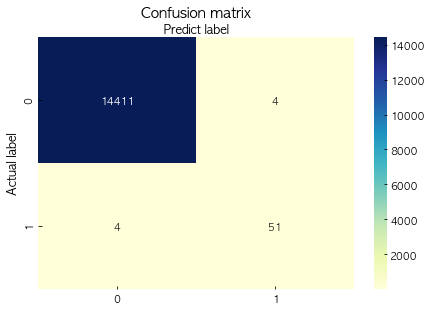

In [42]:
cnf_metrix=metrics.confusion_matrix(y_test, y_pred)
print(cnf_metrix)

class_names = ['malignant', 'benign']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
 
# 히트맵 생성
sns.heatmap(pd.DataFrame(cnf_metrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

* 결로인데, 결로가 아니라고 판단한 4개를 줄이는것이 관건